# Intro to satellite data  II -- regridding

In this notebook we look at:

1) how to plot an image using imshow with a colorbar

2) how to find out which pixels are in a particular lon/lat grid cell so that we can
   regrid the radiances onto a uniform grid
   

In [1]:
from e582utils.data_read import download
import numpy as np
import h5py
import sys
filename = 'MYD021KM.A2016136.2015.006.2016138123353.h5'
download(filename)


MYD021KM.A2016136.2015.006.2016138123353.h5 already exists
and is 155338872 bytes
will not overwrite



Here is the corresponding red,green,blue color composite for the granule.

In [2]:
from IPython.display import Image
Image(url='http://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/aqua_136_2015.jpg',width=600)

In [3]:
### now use h5py to read some of the satellite channels

h5_file=h5py.File(filename)
index31=10
my_name = 'EV_1KM_Emissive'
chan31=h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][my_name][index31,:,:]
scale=h5_file['MODIS_SWATH_Type_L1B']['Data Fields']['EV_1KM_Emissive'].attrs['radiance_scales'][...]
offset=h5_file['MODIS_SWATH_Type_L1B']['Data Fields']['EV_1KM_Emissive'].attrs['radiance_offsets'][...]
chan31_calibrated =(chan31 - offset[index31])*scale[index31]

### New -- plot the radiances as an image

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

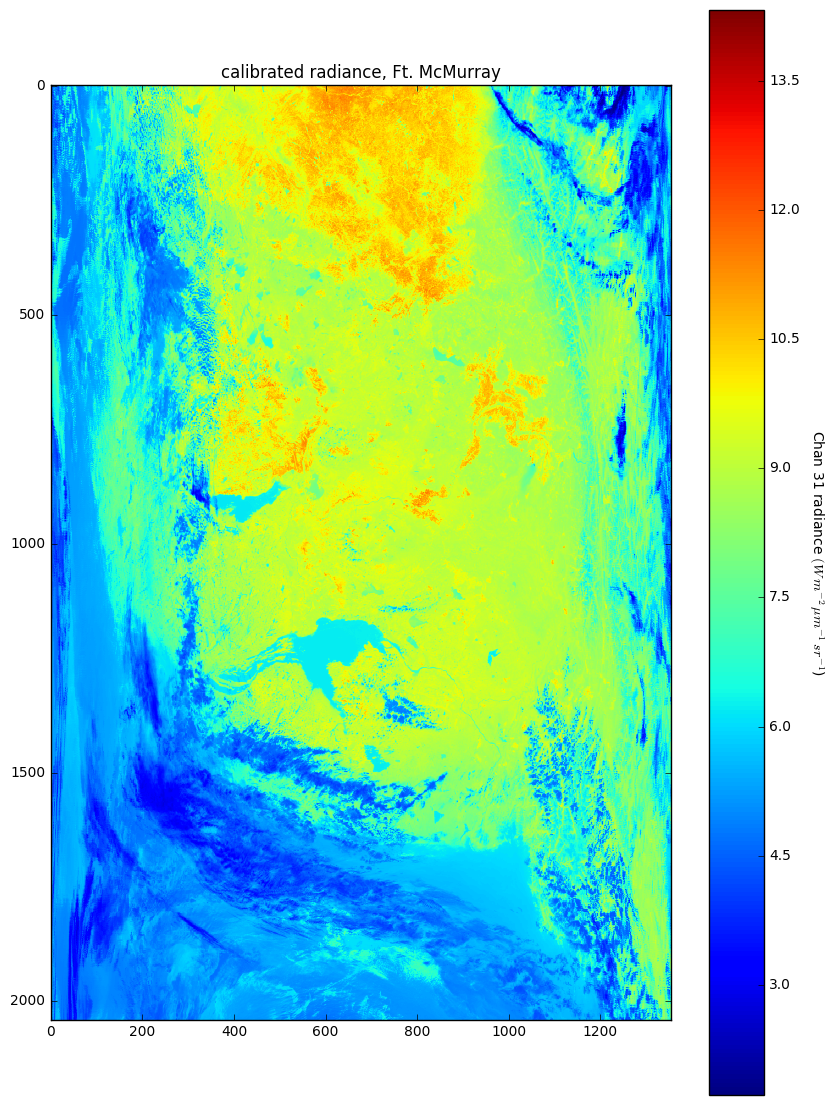

In [5]:
fig,ax = plt.subplots(1,1,figsize = (10,14))
CS=ax.imshow(chan31_calibrated)
cax=fig.colorbar(CS)
ax.set_title('calibrated radiance, Ft. McMurray')
out=cax.ax.set_ylabel('Chan 31 radiance $(W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$)')
out.set_rotation(270)
out.set_verticalalignment('bottom')


### New -- get the full latitude and longitude arrays from the MYD03 (not the smaller arrays that included with the MYD021KM file)

In [6]:
filename='MYD03.A2016136.2015.006.2016138121537.h5'
download(filename)
geo_file = h5py.File(filename)
lon_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Longitude'][...]
lat_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Latitude'][...]


MYD03.A2016136.2015.006.2016138121537.h5 already exists
and is 41848985 bytes
will not overwrite



In [7]:
#
# work through what's going on in this function, using print statements
# if you need them. and answering the 8 questions inline
#
%debug
import pdb

def do_hist(data_vec,numbins,minval,maxval):
    #
    # Q1) describe in words the 4 variables defined between
    # here and the for loop, include what the array shapes are when
    # given 
    #
    #  data_vec -- data pixel values to be binned
    #  numbins-- number of bins in the histogram
    #  minval -- value of the left edge of the histogram bins
    #  maxval -- value of the right edge of th histogram bins
    #  
    #
    #  turn question 1 info on or off with q1 flag
    #
    #
    q1=False
    if q1:
        minval = -124
        maxval = -93
        numbins=30
        #
    # 
    #
    # Q2) Why did I set bin_index to
    #      -1 instead of 0?
    #
    #  because 0 is a valid bin number -- you want to initialize with values
    #  that could not be mistaken for results
    #
    #
    binsize= (maxval - minval)/numbins
    bin_count = np.zeros([numbins,],dtype=np.int)
    bin_index = np.zeros(data_vec.shape,dtype = np.int)
    bin_index[:] = -1
    lowcount=0
    highcount=0 
    #
    #  Q3) which bin number would longitude = -102 go into?
    #
    #    float_bin =  ((-102. - minval) /binsize)
    #    Pdb) float_bin
    #    21.29032258064516  - so bin 21
    #
    #  Q4) what are the left and right bin edges of this bin?
    #
    #       bin_edge[21]
    #       (Pdb) bin_edges[21]
    #       -102.3
    #      (Pdb) bin_edges[22]
    #       -101.26666666666667
    #
    for i in range(len(data_vec)):
        float_bin =  ((data_vec[i] - minval) /binsize)
        if float_bin < 0:
            lowcount+=1
            bin_index[i]= -999.
            continue
        if float_bin >= numbins:
            highcount += 1
            bin_index[i] = -888.
            continue
        int_bin = int(float_bin)
        bin_count[int_bin]+=1
        bin_index[i]=int_bin
    bin_edges=[minval + (i*binsize) for i in range(numbins+1)]
    bin_edges = np.array(bin_edges)
    out = dict(index_vec=bin_index,count_vec=bin_count,edges_vec=bin_edges,
             lowcount=lowcount,highcount=highcount)
    if q1:
        #
        # stop the python debugger here to print variables
        #
        pdb.set_trace()
    return out
#

ERROR:root:No traceback has been produced, nothing to debug.


In [8]:
# Q5) what do these two statements do?
#
#  they first flatten the two-dimensional lon and lat arrays to
#  1 dimension of size rows x columns
#   then they select the first 800 and 900 values respectively of the lon and lat arrays
#

lon_flat = lon_data.ravel()[:800]
lat_flat = lat_data.ravel()[:900]

lon_min= -124
lon_max = -93
numbins=30

lon_hist=do_hist(lon_flat,numbins,lon_min,lon_max)
lat_min = 47
lat_max = 55
numbins=40
#
# now run the function
#
lat_hist=do_hist(lat_flat,numbins,lat_min,lat_max)
print(list(lon_hist.keys()))

['lowcount', 'highcount', 'index_vec', 'edges_vec', 'count_vec']


In [9]:
def find_bins(lon_hist,lat_hist,lon_index,lat_index):
    """
    identify all pixels that have lons in bin lon_index
    and lats in bin lat_index
    
    Parameters
    ----------
    
    lon_hist:  dictionary
        dict returned from do_hist
        
    lat_hist: dictionary
        dict returned from do_hist
        
    lon_index = index of the longitude bin to retrieve
    lat_index = index of the latitude bin to retrieve
    
    Returns
    -------
    
    pixel_list: list
        indices of pixels with lon/lats in the specified lon/lat histogram bin
    """
    keep_lat=[]
    keep_lon=[]
    #
    # Q6) Describe in words what the following two loops do
    #
    #   loop through all pixel latitudes/longitudes (720,000 values) and return
    #   a number between 0 and 719,999 (count) and the bin that latitude/longitude
    #   needs to be placed in (a number between 0 and 29 (lon) and 0 to 39 (lat) in this case)
    #   when that bin number corresponds to the target lat_index or lon_index,
    #   append the count to a list
    #   at the end of the loops we have lists of all pixels with latitudes in bin lat_index
    #   and another list of all pixels with longitudes in bin lon_index
    #
    #
    for count,the_index in enumerate(lat_hist['index_vec']):
        if the_index == lat_index:
            keep_lat.append(count)
    for count,the_index in enumerate(lon_hist['index_vec']):
        if the_index == lon_index:
            keep_lon.append(count)
    #
    # Q7) Describe what intersect1d does
    #
    #  this returns an np array with all pixels that occur in both keep_lat and keep_lon
    #
    pixel_list=np.intersect1d(keep_lat,keep_lon)
    return pixel_list

### use find_bins to pick out the pixels near -111.1 deg W, 50.5 deg N

In [10]:
# Q8) Explain in words why calling np.abs().argmin() in the first line below produces
#  the index of the  bin edge nearest 50.5 
#  Write a 1 line python statement to check whether I've found the
#  left edge of the bin and not the right edge
#
#  suppose we have a bin with edges at latitudes 50.1 and 50.6, then 
#  np.abs(lat_hist['edges_vec'] - (50.5)) will be -0.4 for the left edge (say index 29)
#  and 0.1 for the right edge (say index 30), the minimum will be 0.1 and the index returned
#  by argmin will be the location of that minimum -- the index of the right edge = 30
#  That index will be 1 higher than the index of the bin (29), and so to get the bin index 
#  in this case we would need to subtract 1 from 30.  

#  To check to see that we have a  right edge
#  and need to subtract 1, we could calculate np.sign(lat_hist[30] - 50.5) and subtract 1 if the
#  number was greater than 0.
# 
#
import numpy as np
lat_bin=np.abs(lat_hist['edges_vec'] - (50.5)).argmin()
lon_bin=np.abs(lon_hist['edges_vec'] - (-111.1)).argmin()
(lon_bin,lat_bin)
print(help(np.argmin))

Help on function argmin in module numpy.core.fromnumeric:

argmin(a, axis=None, out=None)
    Returns the indices of the minimum values along an axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        By default, the index is into the flattened array, otherwise
        along the specified axis.
    out : array, optional
        If provided, the result will be inserted into this array. It should
        be of the appropriate shape and dtype.
    
    Returns
    -------
    index_array : ndarray of ints
        Array of indices into the array. It has the same shape as `a.shape`
        with the dimension along `axis` removed.
    
    See Also
    --------
    ndarray.argmin, argmax
    amin : The minimum value along a given axis.
    unravel_index : Convert a flat index into an index tuple.
    
    Notes
    -----
    In case of multiple occurrences of the minimum values, the indices
    corresponding to the first occurrence ar

In [11]:
#
#
# get the two edges for the lon and lat cell
#
lon_vals=lon_hist['edges_vec'][lon_bin:lon_bin+2]
lat_vals=lat_hist['edges_vec'][lat_bin:lat_bin+2]
#
# find the center between the edges
#
lon_center = np.sum(lon_vals)/2.
lat_center = np.sum(lat_vals)/2.
(lon_center,lat_center)

(-111.08333333333333, 50.5)

In [12]:
pixel_ids = find_bins(lon_hist,lat_hist,lon_bin,lat_bin)
print('pixels in both lon bin {} and lat bin {}:\n\n {}'.format(lon_bin,lat_bin,pixel_ids))

pixels in both lon bin 12 and lat bin 17:

 [730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747
 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765
 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783
 784 785 786 787 788 789 790 791 792 793 794 795 796]


### Now pull the radiances for these pixels

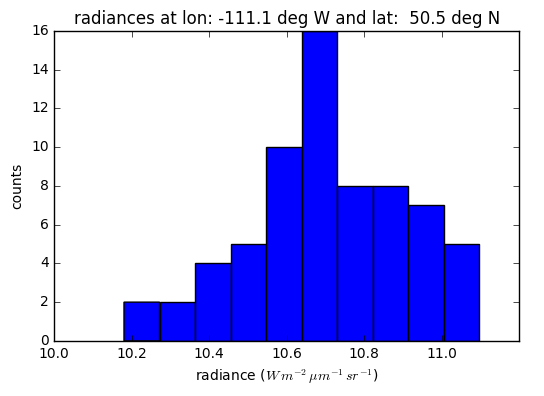

In [13]:
radiances = chan31_calibrated.ravel()[pixel_ids]
fig, ax = plt.subplots(1,1)
ax.hist(radiances)
_=ax.set(ylabel='counts',xlabel='radiance ($W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$)',
        title='radiances at lon: {:5.1f} deg W and lat: {:5.1f} deg N'
         .format(lon_center,lat_center))